In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
@njit
def update_contour(candidate_loc, contour, domain):
    n = len(contour)
    x = candidate_loc[0]
    y = candidate_loc[1]
    domain[x, y] = 0
    contour[x, y] = 1
    neighbours = []
    if x > 0:
        neighbours.append([x-1, y])
    if y > 0:
        neighbours.append([x, y-1])
    if x < n-1:
        neighbours.append([x+1, y])
    if y < n-1:
        neighbours.append([x, y+1])
    for neigh in neighbours:
        if contour[neigh[0], neigh[1]] != 1 and neigh[0] in range(1, n-1) and neigh[1] in range(1, n-1):
            contour[neigh[0], neigh[1]] = 2
    candidates = [[x, y] for x in range(0,n) for y in range(0,n) if contour[x,y] == 2]
    return contour, candidates

def aggregate_candidate(candidates, domain, eta):
    a = [(domain[i, j])**eta for [i, j] in candidates]
    prob_cand = [c/np.sum(a) for c in a]
    agg_cand = candidates[np.random.choice(len(candidates), p = prob_cand)]
    return agg_cand

@njit
def jacobi_iteration(matrix, contour):
    n = len(matrix)
    next_matrix = np.copy(matrix)
        
    for j in range (1, n-1):
        if contour[j,0] == 1:
            next_matrix[j, 0] = 0
        else:
            # west boundary case where x = 0:
            next_matrix[j,0] = 1/4 * (matrix[j,1] + matrix[j,-2] + matrix[j+1,0] + matrix[j-1,0])

        # non-boundary case 
        for i in range (1, n-1):
            if contour[j,i] == 1:
                next_matrix[j, i] = 0
            else:
                next_matrix[j,i] = 1/4 * (matrix[j,i+1] + matrix[j,i-1] + matrix[j+1,i] + matrix[j-1,i])
        if contour[j,-1] == 1:
            next_matrix[j, -1] = 0
        else:
            # east boundary case where x = n:
            next_matrix[j,-1] = 1/4 * (matrix[j,1] + matrix[j,-2] + matrix[j+1,-1] + matrix[j-1,-1])
    return next_matrix

@njit
def jacobi(domain, contour, eps = 1e-5):
    conv = 1
    while conv > eps:
        next_domain = jacobi_iteration(domain, contour)
        diff = np.abs(next_domain - domain)
        conv = np.max(diff)
        domain = next_domain
    return next_domain

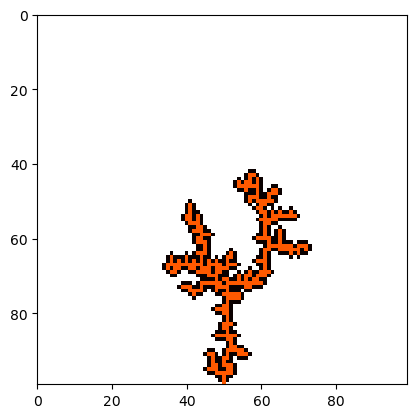

In [28]:
n = 100 # grid length (once squared)
eta = 1.5 # shape parameter 

domain = np.zeros((n, n))
domain[0, :] = 1
contour = np.zeros((n, n))

contour, candidates = update_contour([n-1, n//2], contour, domain)
domain = jacobi(domain, contour)

for _ in range(300):
    cand = aggregate_candidate(candidates, domain, eta)
    contour, candidates = update_contour(cand, contour, domain)
    domain = jacobi(domain, contour)

#color_domain = np.copy(domain)
#if contour[x,y]
im = plt.imshow(contour, cmap='hot_r')
plt.xlim(0, n-1)
plt.ylim(n-1, 0)
plt.show()